In [4]:
from flask import json
import requests
from datetime import datetime
from shapely.geometry import Polygon, MultiPolygon, Point
import geopandas as gpd
from shapely.ops import cascaded_union
import pandas as pd

In [27]:
def iso_req(coor_pair: str, req_min: int):
    """

    """
    # 300 requests per minute
    token = """pk.eyJ1IjoicGFydmF0aHlrcmlzaG5hbmsiLCJhIjoiY2tybGFoMTZwMGJjdDJybnYyemwxY3QxMSJ9.FXaVYsMF3HIzw7ZQFQPhSw"""
    request_url = """https://api.mapbox.com/isochrone/v1/mapbox/driving/"""
    # after the request URL, add the coordinates and isochrone's rule
    # {coordinates}?{contours_minutes|contours_meters}
    time_param = '?contours_minutes=' + str(req_min)
    token_param = "&polygons=true&generalize=100.0&denoise=1.0&access_token="  # to be added the last
    req_iso = request_url + coor_pair + time_param + token_param + token
    request_pack = json.loads(requests.get(req_iso).content)
    if 'features' not in request_pack.keys():
        print('Failed at' + str(datetime.today()))
        return False
    poly_geo = request_pack['features'][0]['geometry']
    iso_poly = Polygon(poly_geo['coordinates'][0])
    return iso_poly

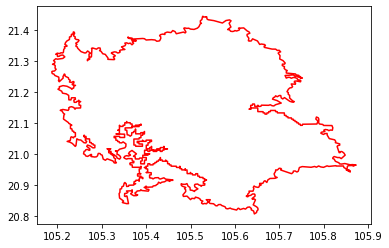

In [32]:
import matplotlib.pyplot as plt

hosp_1 = iso_req('105.496,21.117', 60)
plt.plot(*hosp_1.exterior.xy, color = 'red')

0:00:00.094465


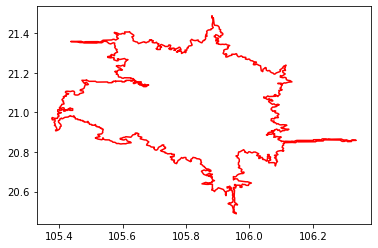

In [33]:
start = datetime.now()
hosp_2 = iso_req('105.790, 21.051', 60)
end = datetime.now()
print(end-start)
plt.plot(*hosp_2.exterior.xy, color = 'red')

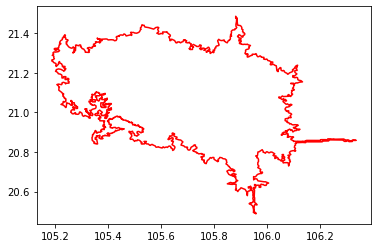

In [34]:
polygons = [hosp_1, hosp_2]
boundary = cascaded_union(polygons)
plt.plot(*boundary.exterior.xy, color = 'red')

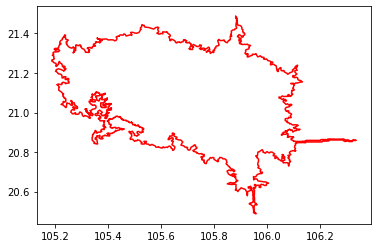

In [23]:
from shapely import wkt

new = wkt.loads(wkt.dumps(boundary, rounding_precision=3))
plt.plot(*new.exterior.xy, color = 'red')

In [12]:
vn_prov = gpd.read_file('../Data/gadm_vietnam.geojson')
# vn_bound = vn_prov.geometry.unary_union
# random_gps(vn_bound)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 279824/279824 [00:03<00:00, 79908.78it/s]


<AxesSubplot:>

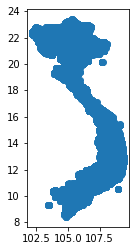

In [20]:
from shapely.geometry import box
from tqdm import tqdm
import numpy as np

coord_df = pd.read_csv('../Data/iso_chrone.csv')
coord_df['FD_5yrs_level'] = np.ones(coord_df.shape[0])
geometry = []
for i in tqdm(range(coord_df.shape[0])):
    lon = coord_df['Lon'][i]
    lat = coord_df['Lat'][i]
#     points = box(lon - 0.005, lat + 0.005, lon - 0.005, lat + 0.005)
    points = Point(lon, lat)
    geometry.append(points)

# geometry = [Point(xy) for xy in zip(map_data.Lon, map_data.Lat)]
coord_df = coord_df.drop(['Lon', 'Lat'], axis=1)
gdf = gpd.GeoDataFrame(coord_df, crs="EPSG:4326", geometry=geometry)
gdf.plot()

<AxesSubplot:>

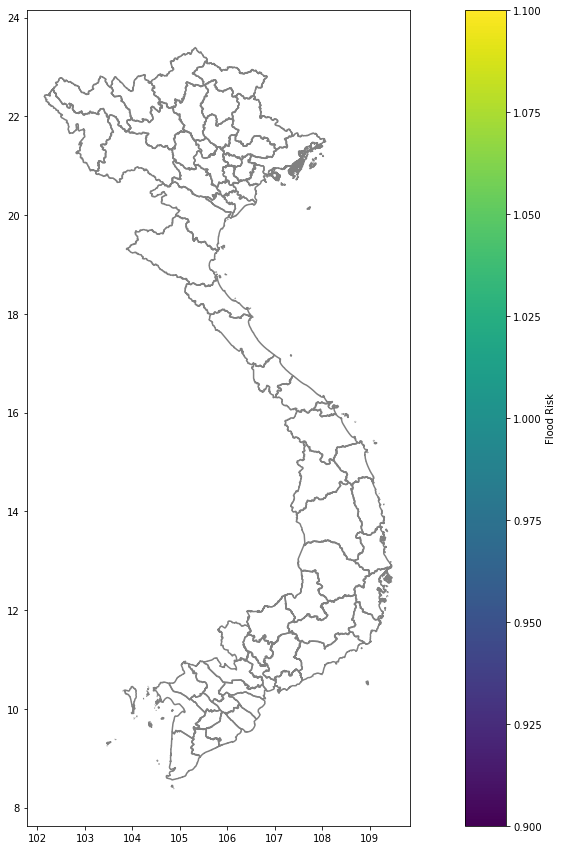

In [18]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(20,15))
vn_map = vn_prov.boundary.plot(ax=ax, color='gray')
gdf.plot(ax=ax, markersize=0.5, column='FD_5yrs_level', legend=True,
         legend_kwds={'label': "Flood Risk"})